In [1]:
import os
import copy

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [166]:
def scale_plot_size(factor=1.3):
    import matplotlib as mpl
    default_dpi = mpl.rcParamsDefault['figure.dpi']
    mpl.rcParams['figure.dpi'] = default_dpi*factor
    
scale_plot_size()

# Read files

In [3]:
!ls ../data/train_100_events/event000001000*

../data/train_100_events/event000001000-cells.csv
../data/train_100_events/event000001000-hits.csv
../data/train_100_events/event000001000-particles.csv
../data/train_100_events/event000001000-truth.csv


In [4]:
DATA_TRAIN_PATH = '../data/train_100_events/'
DATA_TEST_PATH = '../data/test/'

In [5]:
event_one = 'event000001000'

df_train_cells_one = pd.read_csv(os.path.join(DATA_TRAIN_PATH, event_one + '-cells.csv'))
df_train_hits_one = pd.read_csv(os.path.join(DATA_TRAIN_PATH, event_one + '-hits.csv'))
df_train_particles_one = pd.read_csv(os.path.join(DATA_TRAIN_PATH, event_one + '-particles.csv'))
df_train_truth_one = pd.read_csv(os.path.join(DATA_TRAIN_PATH, event_one + '-truth.csv'))

## Start with hits and truth

In [6]:
# For now, drop particle ids of 0 (detector noise)
df_train_truth_one = copy.deepcopy(df_train_truth_one[df_train_truth_one['particle_id'] != 0])

In [175]:
# Calculate the absolute distance from (0, 0, 0), which is needed later
df_train_truth_one['dist'] = \
    np.sqrt(df_train_truth_one['tx']**2 + df_train_truth_one['ty']**2 + df_train_truth_one['tz']**2)

### How many hits does a track create?

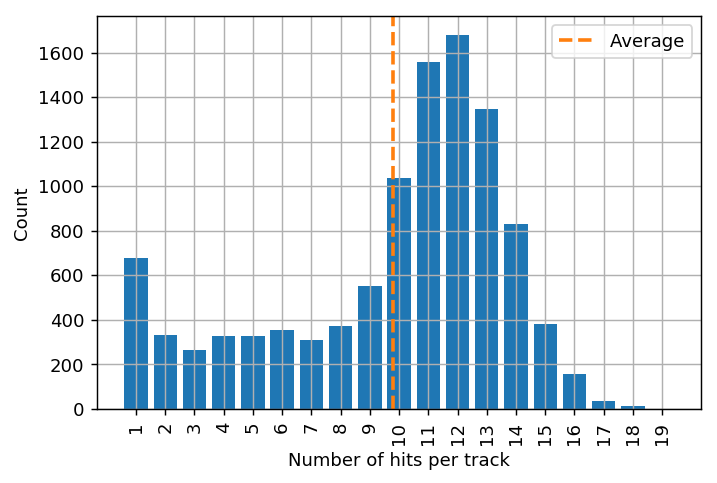

In [172]:
hits_per_track = pd.value_counts(
    pd.value_counts(df_train_truth_one['particle_id'])
).sort_index()

average_hits_per_track = np.average(hits_per_track.index, weights=hits_per_track)

plt.bar(hits_per_track.index, hits_per_track)
plt.xticks(hits_per_track.index,rotation=90)
plt.xlabel('Number of hits per track')
plt.ylabel('Count')
plt.axvline(average_hits_per_track, color='C1', linewidth=2, linestyle='--', label='Average')
plt.grid()
plt.legend()
plt.show()

### How does a track look like in the detector?

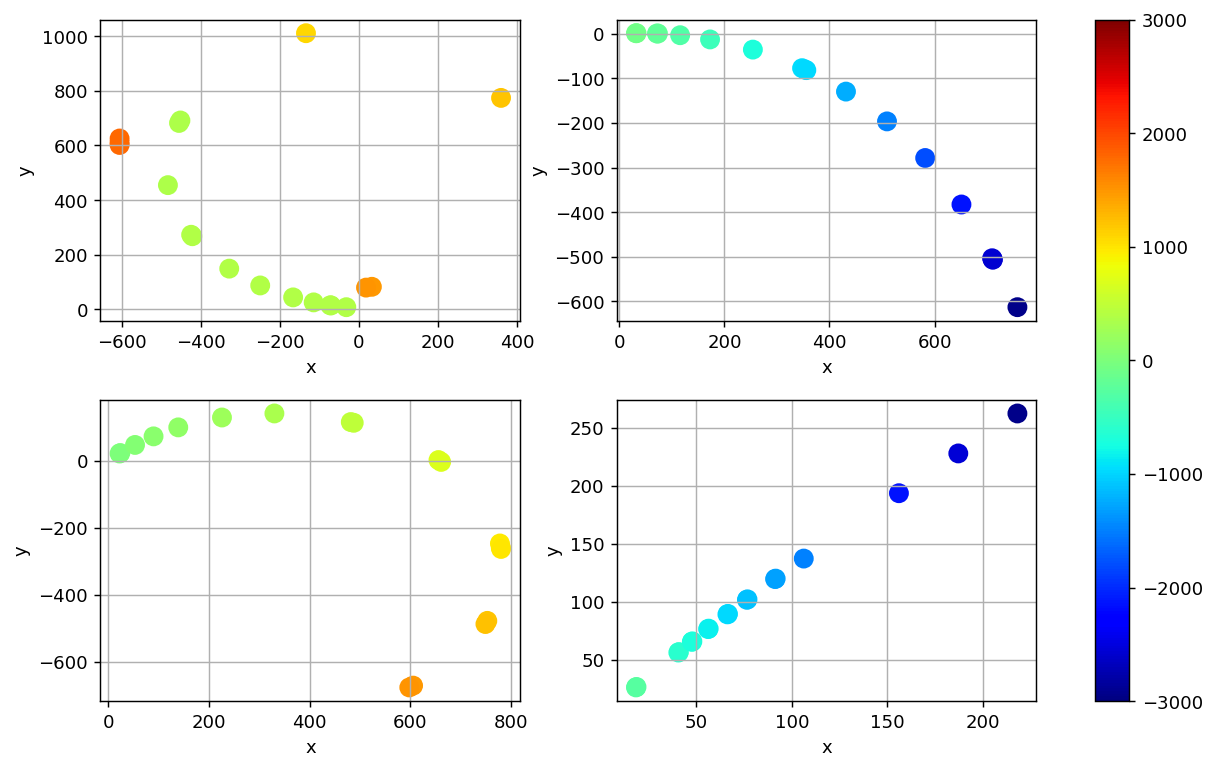

In [176]:
# Specific values chosen for educational purposes
tracks_with_many_hits = pd.value_counts(df_train_truth_one['particle_id']).index[[0, 2, 5, 6]]   

# For better comparison and shared z-axis, calculate the min and max z
max_z = df_train_truth_one['tz'].max().round(-2)
min_z = df_train_truth_one['tz'].min().round(-2)
    
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, ax in enumerate(axes.reshape(-1)):
    df_train_truth_one_track = df_train_truth_one[
        df_train_truth_one['particle_id'] == tracks_with_many_hits[i]
    ].sort_values('dist')

     
    im = ax.scatter(    
        df_train_truth_one_track['tx'], 
        df_train_truth_one_track['ty'],
        s=100,
        c=df_train_truth_one_track['tz'],
        cmap='jet',
        vmin=min_z, 
        vmax=max_z
    )
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.grid()

plt.tight_layout()
fig.colorbar(im, ax=axes.ravel().tolist())

plt.show()

### What distance do particle travel through the detector?

In [38]:
# Taken from this (https://github.com/pandas-dev/pandas/issues/18366) discussion on github,
# we can savely ignore the FutureWarning right now (May 2018)
delta_dist = df_train_truth_one.groupby('particle_id').agg({
    'dist': {
        'delta_dist_simple': lambda pos: max(pos) - min(pos),
        'delta_dist_linear':
    }
})
delta_dist.columns = delta_dist.columns.droplevel(level=0)

/home/timon/miniconda3/envs/ml/lib/python3.6/site-packages/pandas/core/groupby.py:4281: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


In [101]:
def apply_dist(x):
    pos_columns = ['tx', 'ty', 'tz']
    
    d = {}
    d['delta_dist_simple'] = max(x['dist']) - min(x['dist'])
    d['delta_dist_linear'] = np.sum(
        np.sqrt(
            np.sum(
                (x.sort_values('dist')[pos_columns].shift(1) - x.sort_values('dist')[pos_columns])**2, axis=1)
        )
    )
    d['delta_dist_diff'] = d['delta_dist_linear'] - d['delta_dist_simple']
    return pd.Series(d, index=['delta_dist_simple', 'delta_dist_linear', 'delta_dist_diff'])

In [103]:
# TODO: Validate this
# WARNING: Might take ~10s or more
df_train_truth_one.groupby('particle_id').apply(apply_dist)

,delta_dist_simple,delta_dist_linear,delta_dist_diff
particle_id,,,
4503668346847232,1296.878169,1503.033099,206.154930
4503737066323968,1972.387170,1976.560001,4.172831
4503874505277440,1445.883602,1456.222722,10.339119
4503943224754176,82.219471,82.219488,0.000017
4504011944230912,1970.749316,1972.246106,1.496790
4504080663707648,2659.247882,2659.310714,0.062831
4504355541614592,1088.146754,1160.310149,72.163395
4504424261091328,826.956212,829.657225,2.701012
4504424277872641,900.552225,1258.237890,357.685664


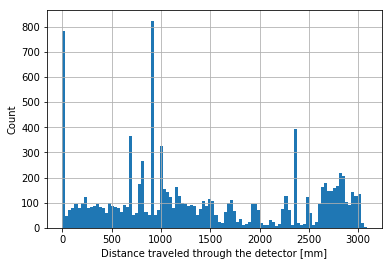

In [39]:
# What distance do the particles flight through the detector?
plt.hist(delta_dist['delta_dist_simple'], bins=100)
plt.xlabel('Distance traveled through the detector [mm]')
plt.ylabel('Count')
plt.grid()
plt.show()

In [76]:
test_df = pd.DataFrame({
    'xs': [2, 3, 1],
    'ys': [2, 1, 3],
    'zs': [2, 4, 5]
})

np.sum(np.sqrt(np.sum((test_df.shift(1) - test_df)**2, axis=1)))

5.4494897427831779

In [73]:
xs = [2, 3, 1]
ys = [2, 1, 3]
zs = [2, 4, 5]

def calc_simple_dist(xs, ys, zs):
    dists = []
    for x, y, z in zip(xs, ys, zs):
        dists.append(np.sqrt(x**2 + y**2 + z**2))
    return max(dists) - min(dists)

def calc_linear_dist(xs, ys, zs):
    linear_dists = []
    for i in range(len(xs) - 1):
        linear_dists.append(
            np.sqrt((xs[i+1] - xs[i])**2 + (ys[i+1] - ys[i])**2 + (zs[i+1] - zs[i])**2)
        )
    print(linear_dists)
    return sum(linear_dists)

simple_dist = calc_simple_dist(xs, ys, zs)
linear_dist = calc_linear_dist(xs, ys, zs)

print(simple_dist, linear_dist)

[2.4494897427831779, 3.0]
2.45197816796 5.44948974278
